In [1]:
import re
import warnings
from pprint import pprint

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

import tqdm
import nltk
import spacy
import gensim
import pyLDAvis
from bertopic import BERTopic
from bertopic.representation import KeyBERTInspired

import pyLDAvis.gensim
import gensim.corpora as corpora
from nltk.corpus import stopwords
from gensim.corpora import Dictionary
from gensim.models import CoherenceModel
from gensim.utils import simple_preprocess
from wordcloud import WordCloud, STOPWORDS

%matplotlib inline
nltk.download("stopwords")
warnings.simplefilter("ignore")

stop_words = stopwords.words("english")

/Users/akindolieoluwatayo/Desktop/school/ai-ds/applied_ai/venv/lib/python3.10/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/Users/akindolieoluwatayo/Desktop/school/ai-ds/applied_ai/venv/lib/python3.10/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/Users/akindol

In [2]:
!python -m spacy download en_core_web_sm
nlp = spacy.load("en_core_web_sm")

In [3]:
df = pd.read_csv("./processed.csv")
df["publish_date"] = pd.to_datetime(df["publish_date"])

df.head()

categories                                              title  \
0      cs.CV  A Semi-automated Statistical Algorithm for Obj...   
1      cs.CV  Classifier Fusion Method to Recognize Handwrit...   
2      cs.LG  A Novel Design Specification Distance(DSD) Bas...   
3      cs.AI  Applying Strategic Multiagent Planning to Real...   
4      cs.CV  A Self-Organizing Neural Scheme for Door Detec...   

                                            abstract              publish_date  
0    We explicate a semi-automated statistical al... 2013-01-01 19:51:28+00:00  
1    Optical Character Recognition (OCR) is one o... 2013-01-02 04:45:44+00:00  
2    Organizing data into semantically more meani... 2013-01-02 07:13:19+00:00  
3    Travel sharing, i.e., the problem of finding... 2013-01-02 12:06:59+00:00  
4    Doors are important landmarks for indoor mob... 2013-01-03 12:04:28+00:00

## Helper functions

In [4]:
def lemmatize(tokens):
    lemmatized = []

    for word in tokens:
        for token in nlp(word):
            lemmatized.append(token.lemma_)

    return lemmatized


def preprocess(text):
    # remove punctuations, convert to lowercase and tokenize
    tokens = simple_preprocess(text, deacc=True)

    # lemmatize
    doc = nlp(" ".join(tokens))

    # remove stopwords
    return [token.lemma_ for token in doc if token.text not in stop_words]

def plot_wordcloud(data):
    text = " ".join(data)
    wordcloud = WordCloud(background_color="#FFF").generate(text)

    plt.figure(figsize=(10, 8))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()

def create_term_doc_freq(processed_series):
    id2word = corpora.Dictionary(processed_series)
    corpus = [id2word.doc2bow(text) for text in processed_series]

    return id2word, processed_series, corpus

def generate_samples(df, n=10000):
    samples = []
    sample_counts = (df["categories"].value_counts(normalize=True) * n).round().astype(int)

    for cat, count in sample_counts.items():
        cat_sample = df[df["categories"] == cat].sample(count, random_state=42)
        samples.append(cat_sample)

    return pd.concat(samples, axis=0).reset_index(drop=True)

## EDA

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84013 entries, 0 to 84012
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype              
---  ------        --------------  -----              
 0   categories    84013 non-null  object             
 1   title         84013 non-null  object             
 2   abstract      84013 non-null  object             
 3   publish_date  84013 non-null  datetime64[ns, GMT]
dtypes: datetime64[ns, GMT](1), object(3)
memory usage: 2.6+ MB


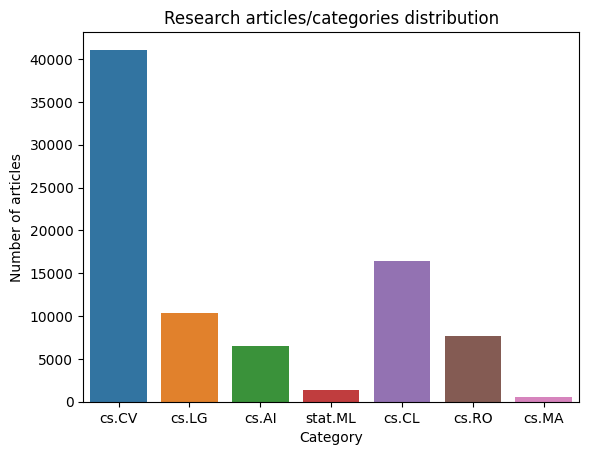

In [6]:
# cs.LG = Machine Learning, cs.CV = Computer Vision and Pattern Recognition, cs.AI = Artificial Intelligence
# cs.CL = Computation and Language (NLP), cs.RO = Robotics, cs.MA = Multiagent Systems, stat.ML = Machine Learning

sns.countplot(data=df, x="categories").set(title="Research articles/categories distribution")
plt.xlabel("Category")
plt.ylabel("Number of articles")
plt.show()

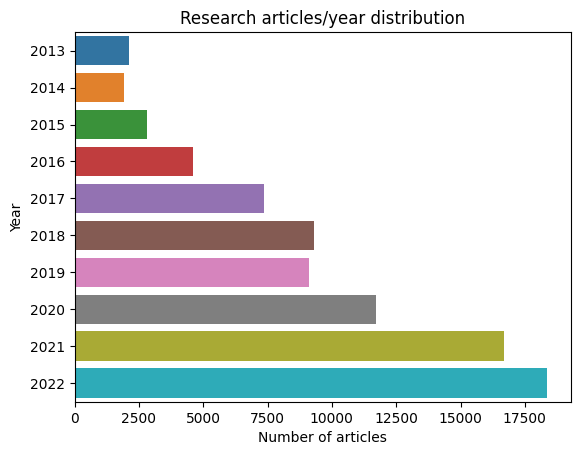

In [7]:
sns.countplot(data=df, y=df["publish_date"].dt.year).set(title="Research articles/year distribution")
plt.xlabel("Number of articles")
plt.ylabel("Year")
plt.show()

## Preprocessing

In [8]:
# combine title and abstract
df["combined_text"] = df["title"] + ' ' + df["abstract"]
df.head()

categories                                              title  \
0      cs.CV  A Semi-automated Statistical Algorithm for Obj...   
1      cs.CV  Classifier Fusion Method to Recognize Handwrit...   
2      cs.LG  A Novel Design Specification Distance(DSD) Bas...   
3      cs.AI  Applying Strategic Multiagent Planning to Real...   
4      cs.CV  A Self-Organizing Neural Scheme for Door Detec...   

                                            abstract  \
0    We explicate a semi-automated statistical al...   
1    Optical Character Recognition (OCR) is one o...   
2    Organizing data into semantically more meani...   
3    Travel sharing, i.e., the problem of finding...   
4    Doors are important landmarks for indoor mob...   

               publish_date                                      combined_text  
0 2013-01-01 19:51:28+00:00  A Semi-automated Statistical Algorithm for Obj...  
1 2013-01-02 04:45:44+00:00  Classifier Fusion Method to Recognize Handwrit...  
2 2013-01-02 07:13:19+00:00  A Novel Design Specification Distance(DSD) Bas...  
3 2013-01-02 12:06:59+00:00  Applying Strategic Multiagent Planning to Real...  
4 2013-01-03 12:04:28+00:00  A Self-Organizing Neural Scheme for Door Detec...

In [9]:
df["publish_date"].dt.year.unique()

array([2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022],
      dtype=int32)

In [10]:
df_first_5_full = df[df["publish_date"].dt.year <= 2017]
df_last_5_full = df[df["publish_date"].dt.year >= 2018]

In [11]:
print(df_first_5_full["publish_date"].dt.year.unique())
print(df_last_5_full["publish_date"].dt.year.unique())

[2013 2014 2015 2016 2017]
[2018 2019 2020 2021 2022]


In [12]:
df_first_5 = generate_samples(df_first_5_full)
df_first_5.head()

categories                                              title  \
0      cs.CV     Latent Embeddings for Zero-shot Classification   
1      cs.CV  Transfer Learning by Ranking for Weakly Superv...   
2      cs.CV  Inference of Haemoglobin Concentration From St...   
3      cs.CV  Drought Stress Classification using 3D Plant M...   
4      cs.CV  Predictive Learning: Using Future Representati...   

                                            abstract  \
0    We present a novel latent embedding model fo...   
1    Most existing approaches to training object ...   
2    Multispectral imaging (MSI) can provide info...   
3    Quantification of physiological changes in p...   
4    The unsupervised Pretraining method has been...   

               publish_date                                      combined_text  
0 2016-03-29 19:24:38+00:00  Latent Embeddings for Zero-shot Classification...  
1 2017-05-02 09:23:27+00:00  Transfer Learning by Ranking for Weakly Superv...  
2 2016-07-11 13:29:54+00:00  Inference of Haemoglobin Concentration From St...  
3 2017-09-21 05:20:13+00:00  Drought Stress Classification using 3D Plant M...  
4 2017-11-25 17:43:12+00:00  Predictive Learning: Using Future Representati...

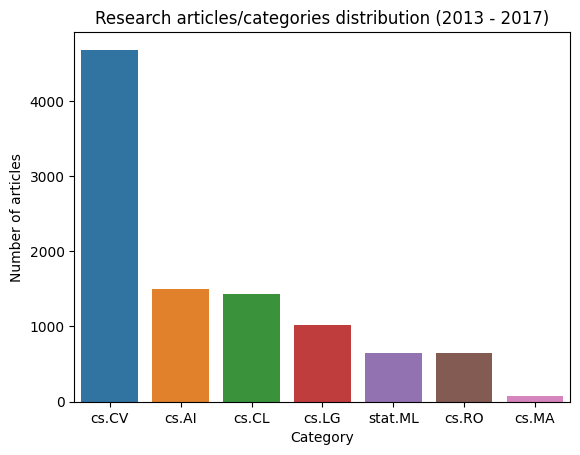

In [13]:
sns.countplot(data=df_first_5, x="categories").set(title="Research articles/categories distribution (2013 - 2017)")
plt.xlabel("Category")
plt.ylabel("Number of articles")
plt.show()

In [15]:
df_last_5 = generate_samples(df_last_5_full)
df_last_5.head()

categories                                              title  \
0      cs.CV              Object-Centric Multi-View Aggregation   
1      cs.CV  Domain Adaptive 3D Pose Augmentation for In-th...   
2      cs.CV  Domain-General Crowd Counting in Unseen Scenarios   
3      cs.CV  Learning to Transfer Texture from Clothing Ima...   
4      cs.CV  Crowd Density Estimation using Novel Feature D...   

                                            abstract  \
0    We present an approach for aggregating a spa...   
1    The ability to perceive 3D human bodies from...   
2    Domain shift across crowd data severely hind...   
3    In this paper, we present a simple yet effec...   
4    Crowd density estimation is an important tas...   

               publish_date                                      combined_text  
0 2020-07-20 17:38:31+00:00  Object-Centric Multi-View Aggregation   We pre...  
1 2022-06-21 15:02:31+00:00  Domain Adaptive 3D Pose Augmentation for In-th...  
2 2022-12-05 19:52:28+00:00  Domain-General Crowd Counting in Unseen Scenar...  
3 2020-03-04 12:53:58+00:00  Learning to Transfer Texture from Clothing Ima...  
4 2019-05-15 00:00:59+00:00  Crowd Density Estimation using Novel Feature D...

10000
10000


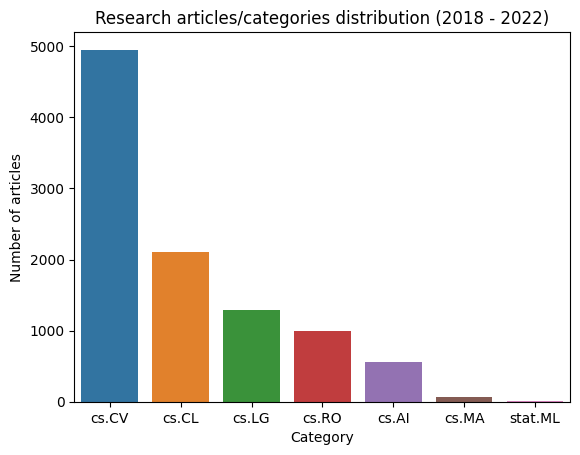

In [16]:
sns.countplot(data=df_last_5, x="categories").set(title="Research articles/categories distribution (2018 - 2022)")
plt.xlabel("Category")
plt.ylabel("Number of articles")
plt.show()

In [17]:
%%time

df_first_5["processed_text"] = df_first_5["combined_text"].apply(preprocess)
df_first_5.head()

CPU times: user 2min 59s, sys: 13.7 s, total: 3min 13s
Wall time: 3min 15s


categories                                              title  \
0      cs.CV     Latent Embeddings for Zero-shot Classification   
1      cs.CV  Transfer Learning by Ranking for Weakly Superv...   
2      cs.CV  Inference of Haemoglobin Concentration From St...   
3      cs.CV  Drought Stress Classification using 3D Plant M...   
4      cs.CV  Predictive Learning: Using Future Representati...   

                                            abstract  \
0    We present a novel latent embedding model fo...   
1    Most existing approaches to training object ...   
2    Multispectral imaging (MSI) can provide info...   
3    Quantification of physiological changes in p...   
4    The unsupervised Pretraining method has been...   

               publish_date  \
0 2016-03-29 19:24:38+00:00   
1 2017-05-02 09:23:27+00:00   
2 2016-07-11 13:29:54+00:00   
3 2017-09-21 05:20:13+00:00   
4 2017-11-25 17:43:12+00:00   

                                       combined_text  \
0  Latent Embeddings for Zero-shot Classification...   
1  Transfer Learning by Ranking for Weakly Superv...   
2  Inference of Haemoglobin Concentration From St...   
3  Drought Stress Classification using 3D Plant M...   
4  Predictive Learning: Using Future Representati...   

                                      processed_text  
0  [latent, embedding, zero, shot, classification...  
1  [transfer, learn, rank, weakly, supervise, obj...  
2  [inference, haemoglobin, concentration, stereo...  
3  [drought, stress, classification, use, plant, ...  
4  [predictive, learning, use, future, representa...

In [18]:
%%time

df_last_5["processed_text"] = df_last_5["combined_text"].apply(preprocess)
df_last_5.head()

CPU times: user 3min 24s, sys: 16.2 s, total: 3min 40s
Wall time: 3min 41s


categories                                              title  \
0      cs.CV              Object-Centric Multi-View Aggregation   
1      cs.CV  Domain Adaptive 3D Pose Augmentation for In-th...   
2      cs.CV  Domain-General Crowd Counting in Unseen Scenarios   
3      cs.CV  Learning to Transfer Texture from Clothing Ima...   
4      cs.CV  Crowd Density Estimation using Novel Feature D...   

                                            abstract  \
0    We present an approach for aggregating a spa...   
1    The ability to perceive 3D human bodies from...   
2    Domain shift across crowd data severely hind...   
3    In this paper, we present a simple yet effec...   
4    Crowd density estimation is an important tas...   

               publish_date  \
0 2020-07-20 17:38:31+00:00   
1 2022-06-21 15:02:31+00:00   
2 2022-12-05 19:52:28+00:00   
3 2020-03-04 12:53:58+00:00   
4 2019-05-15 00:00:59+00:00   

                                       combined_text  \
0  Object-Centric Multi-View Aggregation   We pre...   
1  Domain Adaptive 3D Pose Augmentation for In-th...   
2  Domain-General Crowd Counting in Unseen Scenar...   
3  Learning to Transfer Texture from Clothing Ima...   
4  Crowd Density Estimation using Novel Feature D...   

                                      processed_text  
0  [object, centric, multi, view, aggregation, pr...  
1  [domain, adaptive, pose, augmentation, wild, h...  
2  [domain, general, crowd, count, unseen, scenar...  
3  [learn, transfer, texture, clothing, image, hu...  
4  [crowd, density, estimation, use, novel, featu...

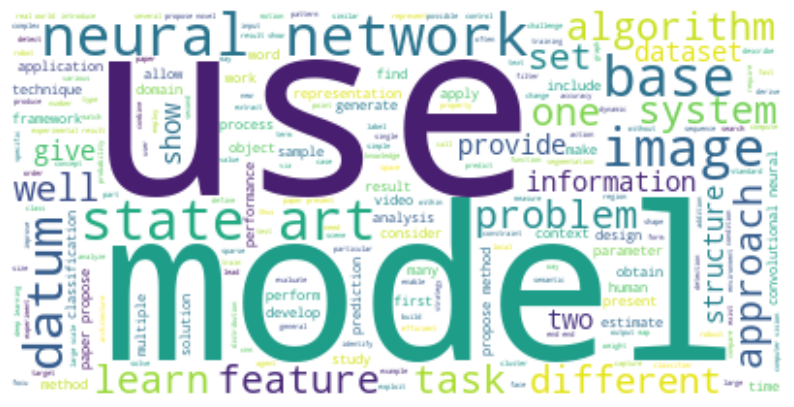

In [19]:
# Word Cloud (2013 - 2017)
plot_wordcloud([" ".join(sublist) for sublist in df_first_5["processed_text"]])

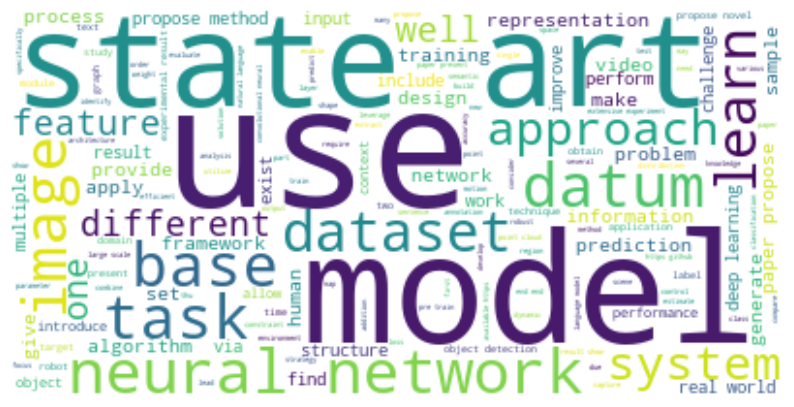

In [20]:
# Word Cloud (2018 - 2022)
plot_wordcloud([" ".join(sublist) for sublist in df_last_5["processed_text"]])

## LDA

In [21]:
id2word_first_5, processed_series_first_5, corpus_first_5 = create_term_doc_freq(df_first_5["processed_text"])
id2word_last_5, processed_series_last_5, corpus_last_5 = create_term_doc_freq(df_last_5["processed_text"])

In [81]:
def runLDAModel(corpus, id2word, processed_series, num_topics, alpha="symmetric", eta=None):
    lda_model = gensim.models.ldamodel.LdaModel(
        eta=eta,
        passes=10,
        alpha=alpha,
        corpus=corpus,
        chunksize=200,
        id2word=id2word,
        random_state=100,
        per_word_topics=True,
        num_topics=num_topics
    )

    # Print the keyword of topics
    # pprint(lda_model.print_topics())
    # doc_lda = lda_model[corpus]

    # validation
    coherence_model_lda = CoherenceModel(model=lda_model, texts=processed_series, dictionary=id2word, coherence="c_v")
    coherence_lda = coherence_model_lda.get_coherence()
    
    print(f"Coherence score: {coherence_lda}")
    
    return lda_model, coherence_lda

def lda_hyperparameter_grid_search(num_topics_range, corpus, id2word, processed_series):
    results = {"num_topics": [], "alpha": [], "beta": [], "coherence_val": []}
    progress_bar = tqdm.tqdm(total=60)

    alpha = [0.01, 0.1, 0.5, "symmetric", "asymmetric"]
    beta = [0.01, 0.1, 0.5, "symmetric"]

    for num_topic in num_topics_range:
        for a in alpha:
            for b in beta:
                model, coherence_val = runLDAModel(corpus, id2word, processed_series, num_topic, a, b)
                
                results["beta"].append(b)
                results["alpha"].append(a)
                results["num_topics"].append(num_topic)
                results["coherence_val"].append(coherence_val)
                
                progress_bar.update(1)
        
    
    progress_bar.close()
    return results

def visualize_topics(cloud, topics):
    fig, axes = plt.subplots(3, 3, figsize=(12, 8), sharex=True, sharey=True)
    
    for i, ax in enumerate(axes.flatten()):
        if i in range(len(topics)):
            topic_words = dict(topics[i][1])
            cloud.generate_from_frequencies(topic_words, max_font_size=250)
            
            ax.imshow(cloud)
            ax.set_title(f"Topic {i}", fontdict=dict(size=20))
            ax.axis("off")

    plt.subplots_adjust(wspace=0, hspace=0)
    plt.axis("off")
    plt.margins(x=0, y=0)
    plt.tight_layout()
    plt.show()

def calculate_bert_coherence_val(model, processed_series, id2word):
    topic_words = {}
    
    for topic in model.get_topics():
        if topic == -1:
            continue
            
        if topic >= 10:
            break
    
        words = [word[0] for word in model.get_topic(topic)]
        topic_words[topic] = words
    
    cm = CoherenceModel(topics=list(topic_words.values()), texts=processed_series, dictionary=id2word, coherence='c_v')
    return cm.get_coherence()

In [23]:
%%time

# compute coherence values for first & last 5 years
model_list_first_5 = []
model_list_last_5 = []
coherence_values_first_5 = []
coherence_values_last_5 = []

range_of_topic_len = range(5, 20)

for num_topics in range_of_topic_len:
    print("*" * 20)
    print(f"Number of topics: {num_topics}")
    
    model_first_5, coherence_val_first_5 = runLDAModel(corpus_first_5, id2word_first_5, processed_series_first_5, num_topics)
    print("-" * 10)
    model_last_5, coherence_val_last_5 = runLDAModel(corpus_last_5, id2word_last_5, processed_series_last_5, num_topics)

    model_list_first_5.append(model_first_5)
    model_list_last_5.append(model_last_5)
    coherence_values_first_5.append(coherence_val_first_5)
    coherence_values_last_5.append(coherence_val_last_5)

********************
Number of topics: 5
Coherence score: 0.395551651703819
----------
Coherence score: 0.3752356952972723
********************
Number of topics: 6
Coherence score: 0.3737379641068758
----------
Coherence score: 0.39481870112599743
********************
Number of topics: 7
Coherence score: 0.39560063925092376
----------
Coherence score: 0.41146616541202885
********************
Number of topics: 8
Coherence score: 0.377362949941829
----------
Coherence score: 0.40120591285497986
********************
Number of topics: 9
Coherence score: 0.35307592307982655
----------
Coherence score: 0.36132800845800084
********************
Number of topics: 10
Coherence score: 0.3902160107742336
----------
Coherence score: 0.378818053478157
********************
Number of topics: 11
Coherence score: 0.38922059553673377
----------
Coherence score: 0.37651008041474615
********************
Number of topics: 12
Coherence score: 0.39301206579461806
----------
Coherence score: 0.3699036024712298

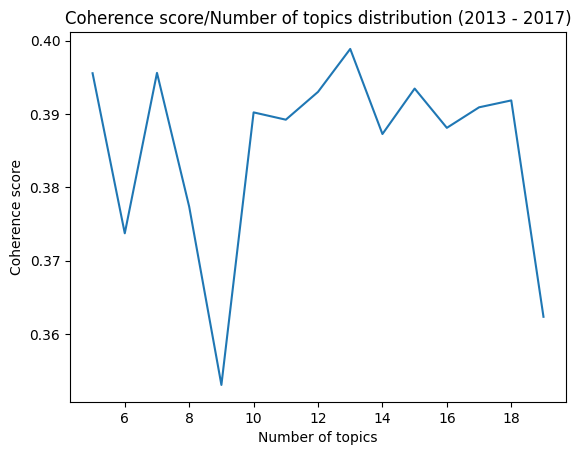

In [25]:
plt.plot(range_of_topic_len, coherence_values_first_5)
plt.xlabel("Number of topics")
plt.ylabel("Coherence score")
plt.title("Coherence score/Number of topics distribution (2013 - 2017)")
plt.show()

In [26]:
for n, cv in zip(range_of_topic_len, coherence_values_first_5):
    print(f"Num of topics: {n}, Coherence val: {cv}")

# 12, 13, 14

Num of topics: 5, Coherence val: 0.395551651703819
Num of topics: 6, Coherence val: 0.3737379641068758
Num of topics: 7, Coherence val: 0.39560063925092376
Num of topics: 8, Coherence val: 0.377362949941829
Num of topics: 9, Coherence val: 0.35307592307982655
Num of topics: 10, Coherence val: 0.3902160107742336
Num of topics: 11, Coherence val: 0.38922059553673377
Num of topics: 12, Coherence val: 0.39301206579461806
Num of topics: 13, Coherence val: 0.3988648718484793
Num of topics: 14, Coherence val: 0.38726787818645425
Num of topics: 15, Coherence val: 0.3934640667012211
Num of topics: 16, Coherence val: 0.38810954370877915
Num of topics: 17, Coherence val: 0.39090726812972154
Num of topics: 18, Coherence val: 0.39184759844702977
Num of topics: 19, Coherence val: 0.3623589655156968


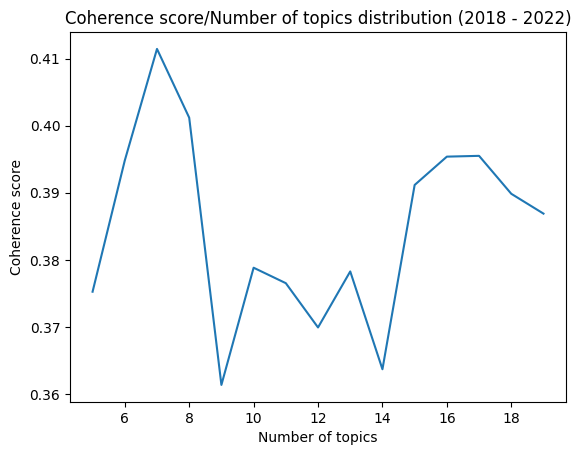

In [27]:
plt.plot(range_of_topic_len, coherence_values_last_5)
plt.xlabel("Number of topics")
plt.ylabel("Coherence score")
plt.title("Coherence score/Number of topics distribution (2018 - 2022)")
plt.show()

In [28]:
for n, cv in zip(range_of_topic_len, coherence_values_last_5):
    print(f"Num of topics: {n}, Coherence val: {cv}")

# 6, 7, 8

Num of topics: 5, Coherence val: 0.3752356952972723
Num of topics: 6, Coherence val: 0.39481870112599743
Num of topics: 7, Coherence val: 0.41146616541202885
Num of topics: 8, Coherence val: 0.40120591285497986
Num of topics: 9, Coherence val: 0.36132800845800084
Num of topics: 10, Coherence val: 0.378818053478157
Num of topics: 11, Coherence val: 0.37651008041474615
Num of topics: 12, Coherence val: 0.36990360247122983
Num of topics: 13, Coherence val: 0.37826235442933837
Num of topics: 14, Coherence val: 0.3636674034486518
Num of topics: 15, Coherence val: 0.3911653840650169
Num of topics: 16, Coherence val: 0.395392857390121
Num of topics: 17, Coherence val: 0.39551065442715033
Num of topics: 18, Coherence val: 0.3898504091928091
Num of topics: 19, Coherence val: 0.3868895538633237


### Hyperparameter tuning

In [29]:
%%time

results_first_5 = lda_hyperparameter_grid_search(range(12, 15), corpus_first_5, id2word_first_5, processed_series_first_5)
results_first_5

  2%|███▋                                                                                                                                                                                                                      | 1/60 [00:59<58:24, 59.39s/it]

Coherence score: 0.3807209421198953


  3%|███████▎                                                                                                                                                                                                                  | 2/60 [01:49<52:24, 54.21s/it]

Coherence score: 0.3851303692795958


  5%|██████████▉                                                                                                                                                                                                               | 3/60 [02:47<52:45, 55.53s/it]

Coherence score: 0.5147273222934027


  7%|██████████████▌                                                                                                                                                                                                           | 4/60 [03:41<51:26, 55.12s/it]

Coherence score: 0.40246772888911986


  8%|██████████████████▏                                                                                                                                                                                                       | 5/60 [04:38<51:11, 55.84s/it]

Coherence score: 0.3836133737456994


 10%|█████████████████████▊                                                                                                                                                                                                    | 6/60 [05:29<48:38, 54.05s/it]

Coherence score: 0.3895630403695098


 12%|█████████████████████████▍                                                                                                                                                                                                | 7/60 [06:25<48:20, 54.74s/it]

Coherence score: 0.48575988093590894


 13%|█████████████████████████████                                                                                                                                                                                             | 8/60 [07:17<46:43, 53.91s/it]

Coherence score: 0.3892393760147456


 15%|████████████████████████████████▋                                                                                                                                                                                         | 9/60 [08:11<45:55, 54.03s/it]

Coherence score: 0.3886963385169831


 17%|████████████████████████████████████▏                                                                                                                                                                                    | 10/60 [09:09<45:52, 55.05s/it]

Coherence score: 0.39160606831231


 18%|███████████████████████████████████████▊                                                                                                                                                                                 | 11/60 [10:07<45:41, 55.95s/it]

Coherence score: 0.4393551581482378


 20%|███████████████████████████████████████████▍                                                                                                                                                                             | 12/60 [11:10<46:35, 58.24s/it]

Coherence score: 0.380576586596406


 22%|███████████████████████████████████████████████                                                                                                                                                                          | 13/60 [12:06<44:57, 57.38s/it]

Coherence score: 0.37769673552180066


 23%|██████████████████████████████████████████████████▋                                                                                                                                                                      | 14/60 [12:55<42:15, 55.12s/it]

Coherence score: 0.38682493032376647


 25%|██████████████████████████████████████████████████████▎                                                                                                                                                                  | 15/60 [13:47<40:25, 53.90s/it]

Coherence score: 0.5018231985910063


 27%|█████████████████████████████████████████████████████████▊                                                                                                                                                               | 16/60 [14:38<39:04, 53.29s/it]

Coherence score: 0.39301206579461806


 28%|█████████████████████████████████████████████████████████████▍                                                                                                                                                           | 17/60 [15:37<39:15, 54.78s/it]

Coherence score: 0.3805533175896605


 30%|█████████████████████████████████████████████████████████████████                                                                                                                                                        | 18/60 [16:28<37:42, 53.87s/it]

Coherence score: 0.3944864519819276


 32%|████████████████████████████████████████████████████████████████████▋                                                                                                                                                    | 19/60 [17:23<36:58, 54.11s/it]

Coherence score: 0.4873486008972805


 33%|████████████████████████████████████████████████████████████████████████▎                                                                                                                                                | 20/60 [18:17<36:04, 54.12s/it]

Coherence score: 0.3963615275574637


 35%|███████████████████████████████████████████████████████████████████████████▉                                                                                                                                             | 21/60 [19:16<36:02, 55.44s/it]

Coherence score: 0.3791672775801235


 37%|███████████████████████████████████████████████████████████████████████████████▌                                                                                                                                         | 22/60 [20:10<34:55, 55.16s/it]

Coherence score: 0.37881889449593237


 38%|███████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                     | 23/60 [21:05<33:57, 55.05s/it]

Coherence score: 0.4658587501560675


 40%|██████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                  | 24/60 [22:00<32:56, 54.92s/it]

Coherence score: 0.40935837364850414


 42%|██████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                              | 25/60 [22:57<32:29, 55.69s/it]

Coherence score: 0.38140659097810015


 43%|██████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                           | 26/60 [23:50<31:01, 54.76s/it]

Coherence score: 0.3919735506452699


 45%|█████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                       | 27/60 [24:43<29:52, 54.33s/it]

Coherence score: 0.47672477163614013


 47%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                   | 28/60 [25:38<29:06, 54.57s/it]

Coherence score: 0.3959236592280648


 48%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                | 29/60 [26:34<28:22, 54.92s/it]

Coherence score: 0.4011244586922705


 50%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                            | 30/60 [27:28<27:17, 54.60s/it]

Coherence score: 0.38391386213826745


 52%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                         | 31/60 [28:23<26:29, 54.82s/it]

Coherence score: 0.4550368755427842


 53%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                     | 32/60 [29:15<25:13, 54.06s/it]

Coherence score: 0.4092251052834723


 55%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                 | 33/60 [30:11<24:35, 54.65s/it]

Coherence score: 0.38657353526212684


 57%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                              | 34/60 [31:04<23:24, 54.01s/it]

Coherence score: 0.385827420251355


 58%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                          | 35/60 [31:56<22:14, 53.37s/it]

Coherence score: 0.4562128694724477


 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                      | 36/60 [32:49<21:16, 53.19s/it]

Coherence score: 0.3988648718484793


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                   | 37/60 [33:44<20:38, 53.85s/it]

Coherence score: 0.37908206910333964


 63%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                               | 38/60 [34:35<19:25, 52.96s/it]

Coherence score: 0.38340596921931397


 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                            | 39/60 [35:28<18:33, 53.01s/it]

Coherence score: 0.5090384033722102


 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                        | 40/60 [37:14<22:56, 68.82s/it]

Coherence score: 0.41038448252544296


 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                    | 41/60 [38:13<20:52, 65.90s/it]

Coherence score: 0.3637311487086648


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                 | 42/60 [39:07<18:42, 62.39s/it]

Coherence score: 0.3609887319985661


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                             | 43/60 [40:08<17:32, 61.91s/it]

Coherence score: 0.4784801843284642


 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                         | 44/60 [41:06<16:13, 60.87s/it]

Coherence score: 0.3865649782617161


 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                      | 45/60 [42:05<15:02, 60.15s/it]

Coherence score: 0.3864898099218163


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                  | 46/60 [43:01<13:44, 58.89s/it]

Coherence score: 0.36991254616319014


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                               | 47/60 [44:01<12:50, 59.24s/it]

Coherence score: 0.4922152253337681


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                           | 48/60 [44:55<11:34, 57.87s/it]

Coherence score: 0.38312076070769024


 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                       | 49/60 [45:52<10:31, 57.38s/it]

Coherence score: 0.3944738990730073


 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 50/60 [46:44<09:18, 55.86s/it]

Coherence score: 0.403315678777122


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                | 51/60 [47:41<08:25, 56.11s/it]

Coherence score: 0.4657032932766882


 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                             | 52/60 [48:34<07:21, 55.15s/it]

Coherence score: 0.3966244080839152


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                         | 53/60 [49:31<06:31, 55.93s/it]

Coherence score: 0.3889624677584386


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                     | 54/60 [50:22<05:27, 54.51s/it]

Coherence score: 0.3732728848644279


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                  | 55/60 [51:18<04:33, 54.69s/it]

Coherence score: 0.48895727533388894


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌              | 56/60 [52:12<03:38, 54.52s/it]

Coherence score: 0.38726787818645425


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 57/60 [53:10<02:47, 55.75s/it]

Coherence score: 0.36858191868586837


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 58/60 [54:04<01:49, 54.99s/it]

Coherence score: 0.3705137327804154


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 59/60 [55:00<00:55, 55.58s/it]

Coherence score: 0.4851039561867611


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 60/60 [55:56<00:00, 55.95s/it]

Coherence score: 0.3829312162959328
CPU times: user 46min 49s, sys: 21.3 s, total: 47min 10s
Wall time: 55min 56s


{'num_topics': [12,
  12,
  12,
  12,
  12,
  12,
  12,
  12,
  12,
  12,
  12,
  12,
  12,
  12,
  12,
  12,
  12,
  12,
  12,
  12,
  13,
  13,
  13,
  13,
  13,
  13,
  13,
  13,
  13,
  13,
  13,
  13,
  13,
  13,
  13,
  13,
  13,
  13,
  13,
  13,
  14,
  14,
  14,
  14,
  14,
  14,
  14,
  14,
  14,
  14,
  14,
  14,
  14,
  14,
  14,
  14,
  14,
  14,
  14,
  14],
 'alpha': [0.01,
  0.01,
  0.01,
  0.01,
  0.1,
  0.1,
  0.1,
  0.1,
  0.5,
  0.5,
  0.5,
  0.5,
  'symmetric',
  'symmetric',
  'symmetric',
  'symmetric',
  'asymmetric',
  'asymmetric',
  'asymmetric',
  'asymmetric',
  0.01,
  0.01,
  0.01,
  0.01,
  0.1,
  0.1,
  0.1,
  0.1,
  0.5,
  0.5,
  0.5,
  0.5,
  'symmetric',
  'symmetric',
  'symmetric',
  'symmetric',
  'asymmetric',
  'asymmetric',
  'asymmetric',
  'asymmetric',
  0.01,
  0.01,
  0.01,
  0.01,
  0.1,
  0.1,
  0.1,
  0.1,
  0.5,
  0.5,
  0.5,
  0.5,
  'symmetric',
  'symmetric',
  'symmetric',
  'symmetric',
  'asymmetric',
  'asymmetric',
  'asymmetri

In [85]:
results_first_5_df = pd.DataFrame(results_first_5)
results_first_5_df

num_topics       alpha       beta  coherence_val
0           12        0.01       0.01       0.380721
1           12        0.01        0.1       0.385130
2           12        0.01        0.5       0.514727
3           12        0.01  symmetric       0.402468
4           12         0.1       0.01       0.383613
5           12         0.1        0.1       0.389563
6           12         0.1        0.5       0.485760
7           12         0.1  symmetric       0.389239
8           12         0.5       0.01       0.388696
9           12         0.5        0.1       0.391606
10          12         0.5        0.5       0.439355
11          12         0.5  symmetric       0.380577
12          12   symmetric       0.01       0.377697
13          12   symmetric        0.1       0.386825
14          12   symmetric        0.5       0.501823
15          12   symmetric  symmetric       0.393012
16          12  asymmetric       0.01       0.380553
17          12  asymmetric        0.1       0.394486
18          12  asymmetric        0.5       0.487349
19          12  asymmetric  symmetric       0.396362
20          13        0.01       0.01       0.379167
21          13        0.01        0.1       0.378819
22          13        0.01        0.5       0.465859
23          13        0.01  symmetric       0.409358
24          13         0.1       0.01       0.381407
25          13         0.1        0.1       0.391974
26          13         0.1        0.5       0.476725
27          13         0.1  symmetric       0.395924
28          13         0.5       0.01       0.401124
29          13         0.5        0.1       0.383914
30          13         0.5        0.5       0.455037
31          13         0.5  symmetric       0.409225
32          13   symmetric       0.01       0.386574
33          13   symmetric        0.1       0.385827
34          13   symmetric        0.5       0.456213
35          13   symmetric  symmetric       0.398865
36          13  asymmetric       0.01       0.379082
37          13  asymmetric        0.1       0.383406
38          13  asymmetric        0.5       0.509038
39          13  asymmetric  symmetric       0.410384
40          14        0.01       0.01       0.363731
41          14        0.01        0.1       0.360989
42          14        0.01        0.5       0.478480
43          14        0.01  symmetric       0.386565
44          14         0.1       0.01       0.386490
45          14         0.1        0.1       0.369913
46          14         0.1        0.5       0.492215
47          14         0.1  symmetric       0.383121
48          14         0.5       0.01       0.394474
49          14         0.5        0.1       0.403316
50          14         0.5        0.5       0.465703
51          14         0.5  symmetric       0.396624
52          14   symmetric       0.01       0.388962
53          14   symmetric        0.1       0.373273
54          14   symmetric        0.5       0.488957
55          14   symmetric  symmetric       0.387268
56          14  asymmetric       0.01       0.368582
57          14  asymmetric        0.1       0.370514
58          14  asymmetric        0.5       0.485104
59          14  asymmetric  symmetric       0.382931

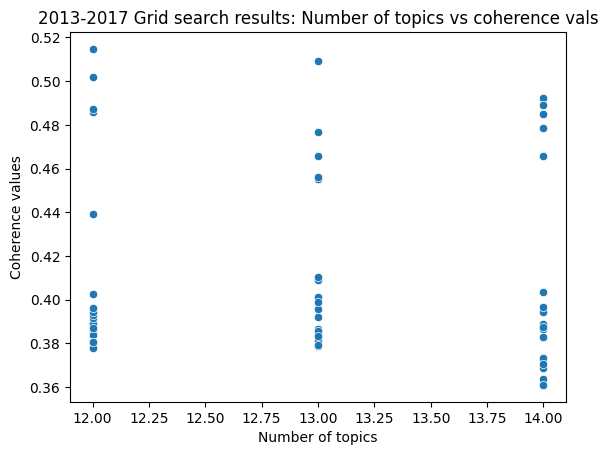

In [87]:
sns.scatterplot(x=results_first_5_df["num_topics"], y=results_first_5_df["coherence_val"])

plt.xlabel("Number of topics")
plt.ylabel("Coherence values")
plt.title("2013-2017 Grid search results: Number of topics vs coherence vals")
plt.show()

In [30]:
# best grid search result for 2013 - 2017
best_config_index = results_first_5["coherence_val"].index(max(results_first_5["coherence_val"]))

print("beta:", results_first_5["beta"][best_config_index])
print("alpha:", results_first_5["alpha"][best_config_index])
print("num of topics:", results_first_5["num_topics"][best_config_index])
print("best coherence val:", max(results_first_5["coherence_val"]))

beta: 0.5
alpha: 0.01
num of topics: 12
best coherence val: 0.5147273222934027


In [31]:
%%time

results_last_5 = lda_hyperparameter_grid_search(range(6, 9), corpus_last_5, id2word_last_5, processed_series_last_5)
results_last_5

  2%|███▋                                                                                                                                                                                                                      | 1/60 [00:54<53:09, 54.07s/it]

Coherence score: 0.3462882734699971


  3%|███████▎                                                                                                                                                                                                                  | 2/60 [01:42<49:13, 50.92s/it]

Coherence score: 0.3877718674794495


  5%|██████████▉                                                                                                                                                                                                               | 3/60 [02:41<51:47, 54.52s/it]

Coherence score: 0.4519640833203284


  7%|██████████████▌                                                                                                                                                                                                           | 4/60 [03:30<48:48, 52.29s/it]

Coherence score: 0.39573691334524996


  8%|██████████████████▏                                                                                                                                                                                                       | 5/60 [04:24<48:39, 53.08s/it]

Coherence score: 0.35898153087147144


 10%|█████████████████████▊                                                                                                                                                                                                    | 6/60 [05:13<46:23, 51.54s/it]

Coherence score: 0.40763848976824185


 12%|█████████████████████████▍                                                                                                                                                                                                | 7/60 [06:08<46:35, 52.75s/it]

Coherence score: 0.44638537085459906


 13%|█████████████████████████████                                                                                                                                                                                             | 8/60 [06:57<44:30, 51.36s/it]

Coherence score: 0.40588216287594103


 15%|████████████████████████████████▋                                                                                                                                                                                         | 9/60 [07:51<44:32, 52.41s/it]

Coherence score: 0.3619611206363636


 17%|████████████████████████████████████▏                                                                                                                                                                                    | 10/60 [08:41<43:02, 51.65s/it]

Coherence score: 0.3829544957361049


 18%|███████████████████████████████████████▊                                                                                                                                                                                 | 11/60 [09:38<43:30, 53.27s/it]

Coherence score: 0.37884525252048434


 20%|███████████████████████████████████████████▍                                                                                                                                                                             | 12/60 [10:31<42:28, 53.10s/it]

Coherence score: 0.37840723529129594


 22%|███████████████████████████████████████████████                                                                                                                                                                          | 13/60 [11:26<41:57, 53.55s/it]

Coherence score: 0.36193948874214116


 23%|██████████████████████████████████████████████████▋                                                                                                                                                                      | 14/60 [12:15<40:07, 52.33s/it]

Coherence score: 0.3831740738698442


 25%|██████████████████████████████████████████████████████▎                                                                                                                                                                  | 15/60 [13:12<40:17, 53.72s/it]

Coherence score: 0.4434287690159742


 27%|█████████████████████████████████████████████████████████▊                                                                                                                                                               | 16/60 [14:02<38:37, 52.67s/it]

Coherence score: 0.39481870112599743


 28%|█████████████████████████████████████████████████████████████▍                                                                                                                                                           | 17/60 [14:57<38:06, 53.17s/it]

Coherence score: 0.346480643884502


 30%|█████████████████████████████████████████████████████████████████                                                                                                                                                        | 18/60 [15:47<36:35, 52.27s/it]

Coherence score: 0.37460900078539877


 32%|████████████████████████████████████████████████████████████████████▋                                                                                                                                                    | 19/60 [16:42<36:16, 53.08s/it]

Coherence score: 0.40373272347357453


 33%|████████████████████████████████████████████████████████████████████████▎                                                                                                                                                | 20/60 [17:35<35:26, 53.16s/it]

Coherence score: 0.40457301041934907


 35%|███████████████████████████████████████████████████████████████████████████▉                                                                                                                                             | 21/60 [18:31<35:11, 54.14s/it]

Coherence score: 0.375461666832234


 37%|███████████████████████████████████████████████████████████████████████████████▌                                                                                                                                         | 22/60 [19:22<33:34, 53.00s/it]

Coherence score: 0.39481505833912994


 38%|███████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                     | 23/60 [20:17<33:05, 53.67s/it]

Coherence score: 0.4433959294759585


 40%|██████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                  | 24/60 [21:08<31:43, 52.86s/it]

Coherence score: 0.40698310237738156


 42%|██████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                              | 25/60 [22:36<36:58, 63.40s/it]

Coherence score: 0.37716127952686435


 43%|██████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                           | 26/60 [23:25<33:33, 59.21s/it]

Coherence score: 0.39774683691194174


 45%|█████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                       | 27/60 [24:20<31:51, 57.93s/it]

Coherence score: 0.43981344390928534


 47%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                   | 28/60 [25:12<29:52, 56.01s/it]

Coherence score: 0.41693688187438915


 48%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                | 29/60 [26:09<29:09, 56.43s/it]

Coherence score: 0.39318972462632457


 50%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                            | 30/60 [27:03<27:49, 55.65s/it]

Coherence score: 0.3760944253456153


 52%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                         | 31/60 [28:03<27:29, 56.89s/it]

Coherence score: 0.4101076096618468


 53%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                     | 32/60 [28:56<25:59, 55.71s/it]

Coherence score: 0.38720268469831004


 55%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                 | 33/60 [29:51<24:59, 55.53s/it]

Coherence score: 0.37741109647223503


 57%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                              | 34/60 [30:40<23:14, 53.63s/it]

Coherence score: 0.402798047156583


 58%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                          | 35/60 [31:34<22:19, 53.57s/it]

Coherence score: 0.4492108413587802


 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                      | 36/60 [32:25<21:06, 52.77s/it]

Coherence score: 0.41146616541202885


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                   | 37/60 [33:21<20:38, 53.85s/it]

Coherence score: 0.3538390245480207


 63%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                               | 38/60 [34:10<19:15, 52.53s/it]

Coherence score: 0.3923760971281829


 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                            | 39/60 [35:04<18:30, 52.87s/it]

Coherence score: 0.4195540760678753


 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                        | 40/60 [35:53<17:16, 51.82s/it]

Coherence score: 0.4129085949691305


 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                    | 41/60 [36:50<16:53, 53.32s/it]

Coherence score: 0.39355521396301796


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                 | 42/60 [37:43<15:56, 53.16s/it]

Coherence score: 0.4089324407720697


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                             | 43/60 [38:42<15:36, 55.07s/it]

Coherence score: 0.4655014813423214


 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                         | 44/60 [39:36<14:35, 54.71s/it]

Coherence score: 0.38216789053188066


 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                      | 45/60 [40:35<13:57, 55.84s/it]

Coherence score: 0.39783852878177456


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                  | 46/60 [41:28<12:50, 55.02s/it]

Coherence score: 0.4022344271203572


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                               | 47/60 [42:25<12:04, 55.74s/it]

Coherence score: 0.44513856283699765


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                           | 48/60 [43:17<10:53, 54.48s/it]

Coherence score: 0.4047522404138


 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                       | 49/60 [44:14<10:08, 55.30s/it]

Coherence score: 0.38117597760354405


 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 50/60 [45:07<09:05, 54.57s/it]

Coherence score: 0.3992000563009602


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                | 51/60 [46:06<08:22, 55.85s/it]

Coherence score: 0.4466397289170876


 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                             | 52/60 [46:58<07:18, 54.78s/it]

Coherence score: 0.3883696757253589


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                         | 53/60 [47:55<06:28, 55.54s/it]

Coherence score: 0.399156336870107


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                     | 54/60 [48:47<05:25, 54.32s/it]

Coherence score: 0.39852637699246124


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                  | 55/60 [49:43<04:33, 54.78s/it]

Coherence score: 0.45852533625227443


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌              | 56/60 [50:34<03:34, 53.64s/it]

Coherence score: 0.40120591285497986


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 57/60 [51:34<02:46, 55.50s/it]

Coherence score: 0.37598225489843395


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 58/60 [52:25<01:48, 54.31s/it]

Coherence score: 0.38799855579289644


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 59/60 [53:21<00:54, 54.64s/it]

Coherence score: 0.41662051800915195


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 60/60 [54:12<00:00, 54.21s/it]

Coherence score: 0.3950490204689955
CPU times: user 45min 50s, sys: 21 s, total: 46min 11s
Wall time: 54min 12s


{'num_topics': [6,
  6,
  6,
  6,
  6,
  6,
  6,
  6,
  6,
  6,
  6,
  6,
  6,
  6,
  6,
  6,
  6,
  6,
  6,
  6,
  7,
  7,
  7,
  7,
  7,
  7,
  7,
  7,
  7,
  7,
  7,
  7,
  7,
  7,
  7,
  7,
  7,
  7,
  7,
  7,
  8,
  8,
  8,
  8,
  8,
  8,
  8,
  8,
  8,
  8,
  8,
  8,
  8,
  8,
  8,
  8,
  8,
  8,
  8,
  8],
 'alpha': [0.01,
  0.01,
  0.01,
  0.01,
  0.1,
  0.1,
  0.1,
  0.1,
  0.5,
  0.5,
  0.5,
  0.5,
  'symmetric',
  'symmetric',
  'symmetric',
  'symmetric',
  'asymmetric',
  'asymmetric',
  'asymmetric',
  'asymmetric',
  0.01,
  0.01,
  0.01,
  0.01,
  0.1,
  0.1,
  0.1,
  0.1,
  0.5,
  0.5,
  0.5,
  0.5,
  'symmetric',
  'symmetric',
  'symmetric',
  'symmetric',
  'asymmetric',
  'asymmetric',
  'asymmetric',
  'asymmetric',
  0.01,
  0.01,
  0.01,
  0.01,
  0.1,
  0.1,
  0.1,
  0.1,
  0.5,
  0.5,
  0.5,
  0.5,
  'symmetric',
  'symmetric',
  'symmetric',
  'symmetric',
  'asymmetric',
  'asymmetric',
  'asymmetric',
  'asymmetric'],
 'beta': [0.01,
  0.1,
  0.5,
  'symmet

In [86]:
results_last_5_df = pd.DataFrame(results_last_5)
results_last_5_df

num_topics       alpha       beta  coherence_val
0            6        0.01       0.01       0.346288
1            6        0.01        0.1       0.387772
2            6        0.01        0.5       0.451964
3            6        0.01  symmetric       0.395737
4            6         0.1       0.01       0.358982
5            6         0.1        0.1       0.407638
6            6         0.1        0.5       0.446385
7            6         0.1  symmetric       0.405882
8            6         0.5       0.01       0.361961
9            6         0.5        0.1       0.382954
10           6         0.5        0.5       0.378845
11           6         0.5  symmetric       0.378407
12           6   symmetric       0.01       0.361939
13           6   symmetric        0.1       0.383174
14           6   symmetric        0.5       0.443429
15           6   symmetric  symmetric       0.394819
16           6  asymmetric       0.01       0.346481
17           6  asymmetric        0.1       0.374609
18           6  asymmetric        0.5       0.403733
19           6  asymmetric  symmetric       0.404573
20           7        0.01       0.01       0.375462
21           7        0.01        0.1       0.394815
22           7        0.01        0.5       0.443396
23           7        0.01  symmetric       0.406983
24           7         0.1       0.01       0.377161
25           7         0.1        0.1       0.397747
26           7         0.1        0.5       0.439813
27           7         0.1  symmetric       0.416937
28           7         0.5       0.01       0.393190
29           7         0.5        0.1       0.376094
30           7         0.5        0.5       0.410108
31           7         0.5  symmetric       0.387203
32           7   symmetric       0.01       0.377411
33           7   symmetric        0.1       0.402798
34           7   symmetric        0.5       0.449211
35           7   symmetric  symmetric       0.411466
36           7  asymmetric       0.01       0.353839
37           7  asymmetric        0.1       0.392376
38           7  asymmetric        0.5       0.419554
39           7  asymmetric  symmetric       0.412909
40           8        0.01       0.01       0.393555
41           8        0.01        0.1       0.408932
42           8        0.01        0.5       0.465501
43           8        0.01  symmetric       0.382168
44           8         0.1       0.01       0.397839
45           8         0.1        0.1       0.402234
46           8         0.1        0.5       0.445139
47           8         0.1  symmetric       0.404752
48           8         0.5       0.01       0.381176
49           8         0.5        0.1       0.399200
50           8         0.5        0.5       0.446640
51           8         0.5  symmetric       0.388370
52           8   symmetric       0.01       0.399156
53           8   symmetric        0.1       0.398526
54           8   symmetric        0.5       0.458525
55           8   symmetric  symmetric       0.401206
56           8  asymmetric       0.01       0.375982
57           8  asymmetric        0.1       0.387999
58           8  asymmetric        0.5       0.416621
59           8  asymmetric  symmetric       0.395049

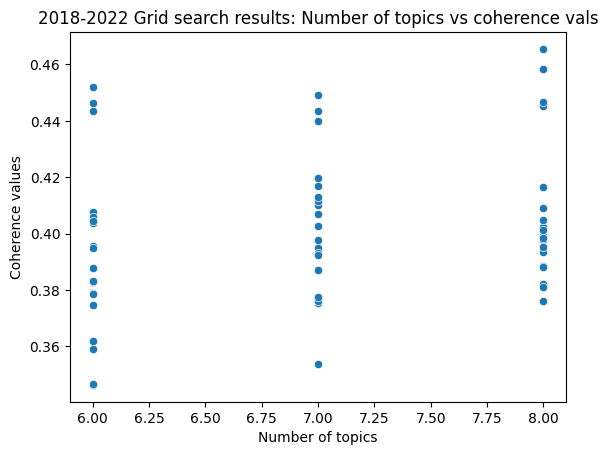

In [88]:
sns.scatterplot(x=results_last_5_df["num_topics"], y=results_last_5_df["coherence_val"])

plt.xlabel("Number of topics")
plt.ylabel("Coherence values")
plt.title("2018-2022 Grid search results: Number of topics vs coherence vals")
plt.show()

In [33]:
# best grid search result for 2018 - 2022
best_config_index = results_last_5["coherence_val"].index(max(results_last_5["coherence_val"]))

print("beta:", results_last_5["beta"][best_config_index])
print("alpha:", results_last_5["alpha"][best_config_index])
print("num of topics:", results_last_5["num_topics"][best_config_index])
print("best coherence val:", max(results_last_5["coherence_val"]))

beta: 0.5
alpha: 0.01
num of topics: 8
best coherence val: 0.4655014813423214


In [34]:
%%time

# best model 2013 - 2017
model_first_5, coherence_val_first_5 = runLDAModel(corpus_first_5, id2word_first_5, processed_series_first_5, 12, 0.01, 0.5)

Coherence score: 0.5147273222934027
CPU times: user 47.9 s, sys: 404 ms, total: 48.3 s
Wall time: 55.6 s


In [36]:
%%time

#best model 2018 - 2022
model_last_5, coherence_val_last_5 = runLDAModel(corpus_last_5, id2word_last_5, processed_series_last_5, 8, 0.01, 0.5)

Coherence score: 0.4655014813423214
CPU times: user 51.7 s, sys: 409 ms, total: 52.1 s
Wall time: 60 s


In [37]:
pyLDAvis.enable_notebook()
vis_prepared_first_5 = pyLDAvis.gensim.prepare(model_first_5, corpus_first_5, id2word_first_5)

vis_prepared_first_5

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
8     -0.346091  0.050046       1        1  50.560159
1     -0.337172  0.058755       2        1  24.200035
3     -0.206086 -0.248388       3        1   8.939208
9     -0.037168  0.202723       4        1   6.026358
10     0.106420  0.008292       5        1   2.972413
0      0.098215 -0.041896       6        1   2.836402
2      0.113308 -0.010880       7        1   1.648951
7      0.116234 -0.034013       8        1   1.575823
5      0.122029  0.002694       9        1   0.361990
11     0.126376  0.005143      10        1   0.338536
4      0.122685  0.002982      11        1   0.272822
6      0.121250  0.004540      12        1   0.267302, topic_info=           Term         Freq        Total Category  logprob  loglift
217     network  6351.000000  6351.000000  Default  30.0000  30.0000
218      neural  3387.000000  3387.000000  Default  29.0000  29.0000
2168      robot  3085.000000  3085.000000  Default  28.0000  28.0000
203        deep  2448.000000  2448.000000  Default  27.0000  27.0000
741    language  1704.000000  1704.000000  Default  26.0000  26.0000
...         ...          ...          ...      ...      ...      ...
1775         th     3.130036    23.193006  Topic12  -6.7838   3.9217
22430       abm     3.556181    35.520572  Topic12  -6.6561   3.6231
1776   workshop     3.544778    39.586376  Topic12  -6.6594   3.5115
22151       mrd     2.440771    19.686638  Topic12  -7.0325   3.8369
903        hold     3.075104   160.836201  Topic12  -6.8015   1.9675

[637 rows x 6 columns], token_table=       Topic      Freq     Term
term                           
19493      1  0.243453     aadt
19493      2  0.121726     aadt
19493      3  0.121726     aadt
19493      4  0.121726     aadt
19493      6  0.121726     aadt
...      ...       ...      ...
1601       9  0.476748  wrinkle
1016       1  0.145443  youtube
1016       4  0.072721  youtube
1016       6  0.072721  youtube
1016       8  0.581771  youtube

[3174 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[9, 2, 4, 10, 11, 1, 3, 8, 6, 12, 5, 7])

In [38]:
vis_prepared_last_5 = pyLDAvis.gensim.prepare(model_last_5, corpus_last_5, id2word_last_5)
vis_prepared_last_5

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
5     -0.237859  0.014452       1        1  34.703959
0     -0.151660  0.095209       2        1  20.959889
2     -0.147887  0.064339       3        1  19.088512
1     -0.136201  0.028978       4        1  13.673005
3     -0.031996 -0.298869       5        1   7.976643
4      0.233698  0.058888       6        1   1.626316
6      0.243491 -0.029028       7        1   1.379164
7      0.228414  0.066031       8        1   0.592513, topic_info=             Term         Freq        Total Category  logprob  loglift
619         graph  6302.000000  6302.000000  Default  30.0000  30.0000
634         robot  3839.000000  3839.000000  Default  29.0000  29.0000
53         system  4907.000000  4907.000000  Default  28.0000  28.0000
3986        agent  2571.000000  2571.000000  Default  27.0000  27.0000
504         label  3480.000000  3480.000000  Default  26.0000  26.0000
...           ...          ...          ...      ...      ...      ...
24939        tcsp    11.226909    34.238555   Topic8  -6.4296   4.0135
25451  evacuation    10.137650    26.997071   Topic8  -6.5317   4.1491
25189        swrl     9.774931    24.124254   Topic8  -6.5681   4.2252
24938         stp     9.786592    25.194323   Topic8  -6.5669   4.1829
1494           de    12.387530   113.748724   Topic8  -6.3313   2.9113

[529 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
253       1  0.796383  accuracy
253       2  0.088958  accuracy
253       3  0.084016  accuracy
253       4  0.029653  accuracy
254       1  0.372941   achieve
...     ...       ...       ...
371       1  0.122087      zero
371       2  0.871510      zero
371       3  0.001878      zero
371       4  0.001878      zero
371       5  0.001878      zero

[2051 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[6, 1, 3, 2, 4, 5, 7, 8])

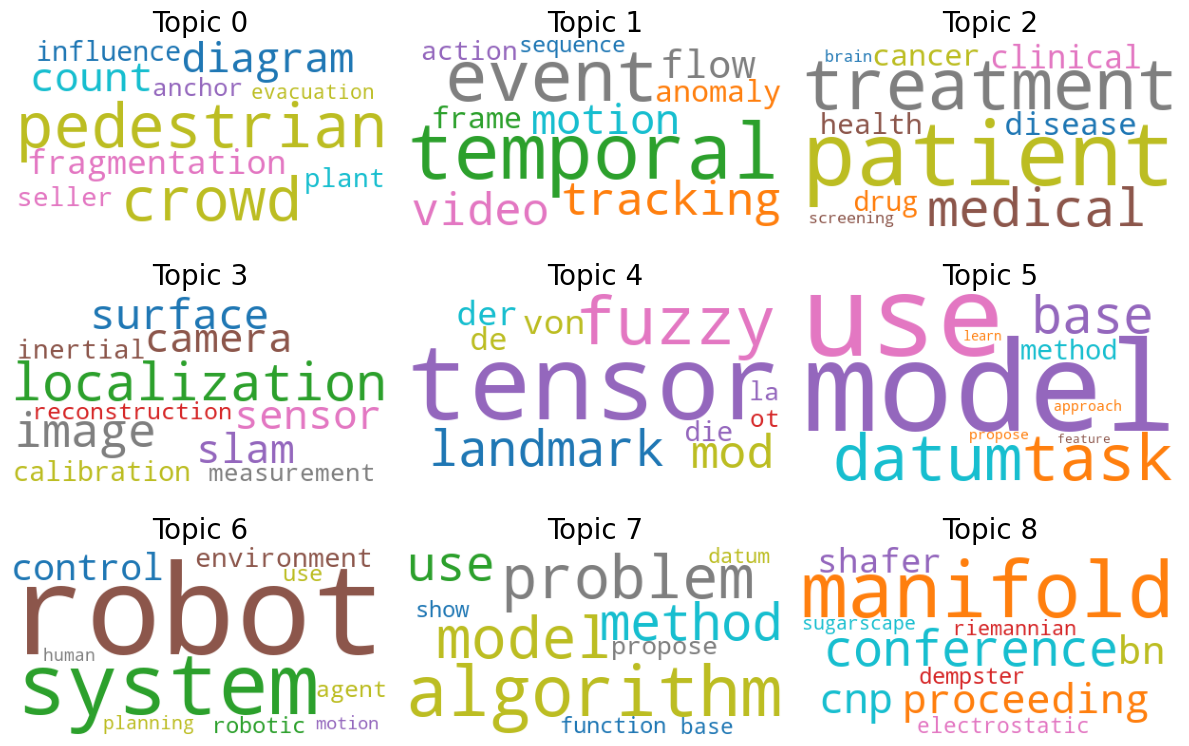

In [82]:
# visualize top topics between 2013 and 2017

# cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]
cloud = WordCloud(
    # width=2500,
    # height=2800,
    max_words=10, 
    colormap="tab10",
    stopwords=stop_words,
    prefer_horizontal=1.0,
    background_color="#FFF",
)

topics_first_5 = model_first_5.show_topics(formatted=False)
visualize_topics(cloud, topics_first_5)

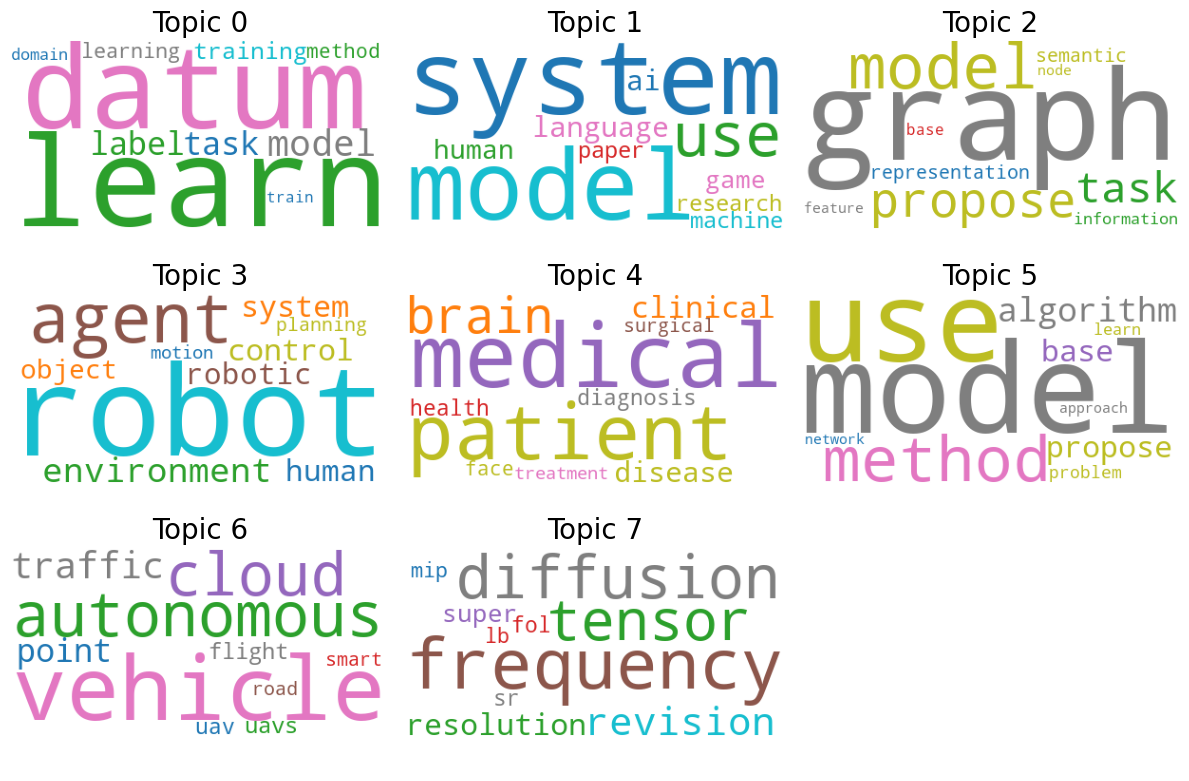

In [83]:
# visualize top topics between 2018 and 2022
topics_last_5 = model_last_5.show_topics(formatted=False)
visualize_topics(cloud, topics_last_5)

## BERTopic

In [41]:
%%time 

# train 2013 - 2017 without a representation model
topic_model_first_5_no_representation = BERTopic(language="english", embedding_model="all-MiniLM-L6-v2")
topics_first_5_no_representation, probs_first_5_no_representation = topic_model_first_5_no_representation.fit_transform(df_first_5["combined_text"])

CPU times: user 32min 16s, sys: 3min 6s, total: 35min 23s
Wall time: 6min 22s


In [42]:
%%time 

# train 2013 - 2017
topic_model_first_5 = BERTopic(language="english", embedding_model="all-MiniLM-L6-v2", representation_model=KeyBERTInspired())
topics_first_5, probs_first_5 = topic_model_first_5.fit_transform(df_first_5["combined_text"])

CPU times: user 33min 47s, sys: 3min 17s, total: 37min 4s
Wall time: 6min 24s


In [43]:
%%time 

# train 2018 - 2022 without a representation model
topic_model_last_5_no_representation = BERTopic(language="english", embedding_model="all-MiniLM-L6-v2")
topics_last_5_no_representation, probs_last_5_no_representation = topic_model_last_5_no_representation.fit_transform(df_last_5["combined_text"])

CPU times: user 33min 47s, sys: 3min 31s, total: 37min 18s
Wall time: 6min 25s


In [44]:
%%time 

# train 2018 - 2022
topic_model_last_5 = BERTopic(language="english", embedding_model="all-MiniLM-L6-v2", representation_model=KeyBERTInspired())
topics_last_5, probs_last_5 = topic_model_last_5.fit_transform(df_last_5["combined_text"])

CPU times: user 37min 4s, sys: 3min 51s, total: 40min 55s
Wall time: 7min 5s


In [45]:
topic_model_first_5.get_topic_info()

Topic  Count                                               Name  \
0       -1   3457    -1_recognition_classification_learning_features   
1        0    210                 0_actions_action_videos_activities   
2        1    200                  1_planning_planner_planners_paths   
3        2    146      2_segmentation_thresholding_segmented_segment   
4        3    138                  3_tracking_tracker_trackers_track   
..     ...    ...                                                ...   
159    158     11                     158_text_recognition_texts_ocr   
160    159     11  159_kernels_empirical_nonparametric_distributions   
161    160     11                      160_sar_wavelet_speckle_radar   
162    161     11                         161_dietary_cnn_foods_food   
163    162     10              162_imagery_supervised_land_satellite   

                                        Representation  \
0    [recognition, classification, learning, featur...   
1    [actions, action, videos, activities, activity...   
2    [planning, planner, planners, paths, trajector...   
3    [segmentation, thresholding, segmented, segmen...   
4    [tracking, tracker, trackers, track, tracked, ...   
..                                                 ...   
159  [text, recognition, texts, ocr, wavelets, dete...   
160  [kernels, empirical, nonparametric, distributi...   
161  [sar, wavelet, speckle, radar, polarization, t...   
162  [dietary, cnn, foods, food, cnns, nutrition, d...   
163  [imagery, supervised, land, satellite, maps, l...   

                                   Representative_Docs  
0    [Dual Local-Global Contextual Pathways for Rec...  
1    [Improving Human Action Recognition by Non-act...  
2    [Stochastic Functional Gradient for Motion Pla...  
3    [Dominant Sets for "Constrained" Image Segment...  
4    [Real-time visual tracking by deep reinforced ...  
..                                                 ...  
159  [Video Text Localization with an emphasis on E...  
160  [Nonparametric Detection of Geometric Structur...  
161  [Iterative Bilateral Filtering of Polarimetric...  
162  [DeepFood: Deep Learning-Based Food Image Reco...  
163  [Automatic Detection of Solar Photovoltaic Arr...  

[164 rows x 5 columns]

In [46]:
topic_model_last_5.get_topic_info()

Topic  Count                                               Name  \
0       -1   3258                  -1_images_learning_neural_trained   
1        0    416                 0_cnn_supervised_segmentation_deep   
2        1    169  1_translations_multilingual_translating_transl...   
3        2    165           2_dialogue_dialogues_dialog_conversation   
4        3    156                 3_action_actions_videos_activities   
..     ...    ...                                                ...   
167    166     10  166_classifiers_classification_imbalance_imbal...   
168    167     10    167_supervised_learning_adaptation_segmentation   
169    168     10                      168_nlp_corpus_tweets_twitter   
170    169     10             169_topics_contextualized_topic_corpus   
171    170     10               170_discourse_corpus_parsing_parsers   

                                        Representation  \
0    [images, learning, neural, trained, classifica...   
1    [cnn, supervised, segmentation, deep, neural, ...   
2    [translations, multilingual, translating, tran...   
3    [dialogue, dialogues, dialog, conversation, co...   
4    [action, actions, videos, activities, activity...   
..                                                 ...   
167  [classifiers, classification, imbalance, imbal...   
168  [supervised, learning, adaptation, segmentatio...   
169  [nlp, corpus, tweets, twitter, depressive, dep...   
170  [topics, contextualized, topic, corpus, embedd...   
171  [discourse, corpus, parsing, parsers, parser, ...   

                                   Representative_Docs  
0    [CrossTransformers: spatially-aware few-shot t...  
1    [Self-Supervision with Superpixels: Training F...  
2    [A General Framework for Adaptation of Neural ...  
3    [Comprehensive Study: How the Context Informat...  
4    [A Proposal-Based Solution to Spatio-Temporal ...  
..                                                 ...  
167  [A Synthetic Over-sampling method with Minorit...  
168  [Scribble-based Domain Adaptation via Co-segme...  
169  [InfyNLP at SMM4H Task 2: Stacked Ensemble of ...  
170  [Nested Variational Autoencoder for Topic Mode...  
171  [Towards Unification of Discourse Annotation F...  

[172 rows x 5 columns]

In [47]:
topic_model_first_5.visualize_topics()

In [48]:
# visualize top 11
topic_model_first_5.visualize_topics(top_n_topics=11, title="<b>Intertopic Distance Map (2013 - 2017)</b>")

In [49]:
topic_model_last_5.visualize_topics()

In [50]:
# visualize top 11
topic_model_last_5.visualize_topics(top_n_topics=11, title="<b>Intertopic Distance Map (2018 - 2022)</b>")

In [104]:
topic_model_first_5.visualize_barchart(width=280, height=330, top_n_topics=10, n_words=10, title="Topic Word Scores (2013 - 2017)")

In [105]:
topic_model_last_5.visualize_barchart(width=280, height=330, top_n_topics=10, n_words=10, title="Topic Word Scores (2018 - 2022)")

In [53]:
# coherence val for 2013 - 2017 (no representation model)
calculate_bert_coherence_val(topic_model_first_5_no_representation, processed_series_first_5, id2word_first_5)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

0.6752615148517664

In [54]:
# coherence val for 2013 - 2017
calculate_bert_coherence_val(topic_model_first_5, processed_series_first_5, id2word_first_5)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

0.5036427646126459

In [55]:
# coherence val for 2018 - 2022 (no representation model)
calculate_bert_coherence_val(topic_model_last_5_no_representation, processed_series_last_5, id2word_last_5)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

0.6410571757378838

In [56]:
# coherence val for 2018 - 2022
calculate_bert_coherence_val(topic_model_last_5, processed_series_last_5, id2word_last_5)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

0.6262409487972584

In [103]:
%%time 

topics_over_time_first_5 = topic_model_first_5.topics_over_time(df_first_5["combined_text"], df_first_5["publish_date"].dt.year)
topic_model_first_5.visualize_topics_over_time(topics_over_time_first_5, topics=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9], width=1000, title="<b>Topics over Time (2013 - 2017)</b>",)

CPU times: user 10min, sys: 56.5 s, total: 10min 56s
Wall time: 1min 57s


In [102]:
%%time 

topics_over_time_last_5 = topic_model_last_5.topics_over_time(df_last_5["combined_text"], df_last_5["publish_date"].dt.year)
topic_model_last_5.visualize_topics_over_time(topics_over_time_last_5, topics=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9], width=1000, title="<b>Topics over Time (2018 - 2022)</b>",)

CPU times: user 13min 27s, sys: 1min 20s, total: 14min 47s
Wall time: 2min 47s
